<a href="https://colab.research.google.com/github/Hadiqapieas/Custom-Model-Architectures/blob/ResNet50/ResNet50c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
# Define Residual Block
# Define Residual Block
class ResidualBlock(nn.Module):
    expansion = 1


    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet50(num_classes=2):
    return ResNet50(num_classes)

In [13]:
# Define Custom ResNet50 Model
# Define Custom ResNet50 Model
class CustomResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(CustomResNet50, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * block.expansion, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize and Print the Model
model = CustomResNet50(ResidualBlock, [3, 4, 6, 3], num_classes=2)
print(model)


CustomResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [15]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# Data Loaders
train_dir = '/content/train_dataset'
val_dir = '/content/validation_dataset'
test_dir = '/content/test_dataset'

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_test_transform)
test_dataset = ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



In [17]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

    model.eval()
    val_running_loss = 0.0
    corrects = 0
    all_labels = []
    all_preds = []
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_acc = corrects.double() / len(val_loader.dataset)
    print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_acc:.4f}')

Epoch 0/9, Loss: 0.4066
Validation Loss: 0.3095, Accuracy: 0.8630
Epoch 1/9, Loss: 0.2255
Validation Loss: 0.5358, Accuracy: 0.6994
Epoch 2/9, Loss: 0.1620
Validation Loss: 0.2178, Accuracy: 0.9100
Epoch 3/9, Loss: 0.1267
Validation Loss: 0.0922, Accuracy: 0.9591
Epoch 4/9, Loss: 0.1155
Validation Loss: 0.1682, Accuracy: 0.9550
Epoch 5/9, Loss: 0.1367
Validation Loss: 0.7351, Accuracy: 0.6483
Epoch 6/9, Loss: 0.1170
Validation Loss: 0.0870, Accuracy: 0.9632
Epoch 7/9, Loss: 0.0837
Validation Loss: 0.0726, Accuracy: 0.9632
Epoch 8/9, Loss: 0.0710
Validation Loss: 0.0624, Accuracy: 0.9755
Epoch 9/9, Loss: 0.0672
Validation Loss: 0.0680, Accuracy: 0.9734


Validation Precision: 0.9745, Recall: 0.9734, F1 Score: 0.9738


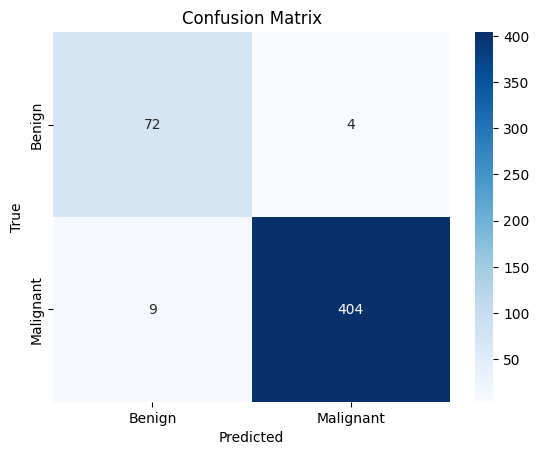

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.95      0.92        76
   Malignant       0.99      0.98      0.98       413

    accuracy                           0.97       489
   macro avg       0.94      0.96      0.95       489
weighted avg       0.97      0.97      0.97       489



In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Compute additional metrics
val_precision = precision_score(all_labels, all_preds, average='weighted')
val_recall = recall_score(all_labels, all_preds, average='weighted')
val_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

Test Loss: 0.0851, Accuracy: 0.9673
Test Precision: 0.9688, Recall: 0.9673, F1 Score: 0.9678


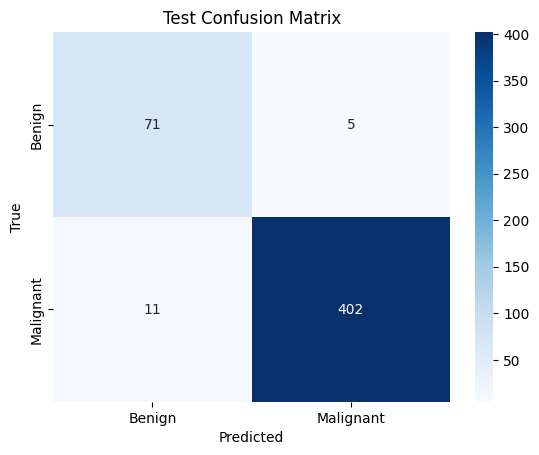

Test Classification Report:
              precision    recall  f1-score   support

      Benign       0.87      0.93      0.90        76
   Malignant       0.99      0.97      0.98       413

    accuracy                           0.97       489
   macro avg       0.93      0.95      0.94       489
weighted avg       0.97      0.97      0.97       489



In [20]:
# Test the Model
model.eval()
test_running_loss = 0.0
corrects = 0
all_test_labels = []
all_test_preds = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())
test_epoch_loss = test_running_loss / len(test_loader.dataset)
test_acc = corrects.double() / len(test_loader.dataset)
print(f'Test Loss: {test_epoch_loss:.4f}, Accuracy: {test_acc:.4f}')

# Compute additional metrics for test set
test_precision = precision_score(all_test_labels, all_test_preds, average='weighted')
test_recall = recall_score(all_test_labels, all_test_preds, average='weighted')
test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
print(f'Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')

# Confusion Matrix for test set
cm = confusion_matrix(all_test_labels, all_test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Classification Report for test set
print('Test Classification Report:')
print(classification_report(all_test_labels, all_test_preds, target_names=['Benign', 'Malignant']))

In [21]:
torch.save(model, 'model.pth')